# Homework 6: Q1, Q2, Q3

This notebook answers:
- **Q1:** Implement a Metropolis-within-Gibbs sampler for a location-scale t model.
- **Q2:** Explore the impact of sample size on inference for the degrees of freedom parameter \(\nu\) using PyMC.
- **Q3:** Derive the posterior predictive distribution by integrating out the latent variable \(\tau_i\) and explain its relevance.

## Q1: Metropolis-within-Gibbs Sampler for a Location-Scale t Model

I divided this problem into four main steps:

1. **Data Simulation and Prior Setup:**  
   Simulate \(n=100\) observations from a t-distribution with known parameters and set priors for \(\mu\), \(\sigma^2\), and \(\nu\) (using a discrete uniform prior on \(\{1, \dots, 100\}\)).

2. **Gibbs Updates for \(\lambda_i\), \(\mu\), and \(\sigma^2\):**  
   - Update each latent variable \(\lambda_i\) from its Gamma full conditional.
   - Update \(\mu\) from its Normal full conditional.
   - Update \(\sigma^2\) from its inverse-gamma full conditional.

3. **Metropolis-Hastings Update for \(\nu\):**  
   Use a random-walk proposal for \(\nu\) (ensuring it remains between 1 and 100) and compute the acceptance probability on the log-scale.

4. **Diagnostics:**  
   Plot trace and histogram for each parameter to assess convergence.

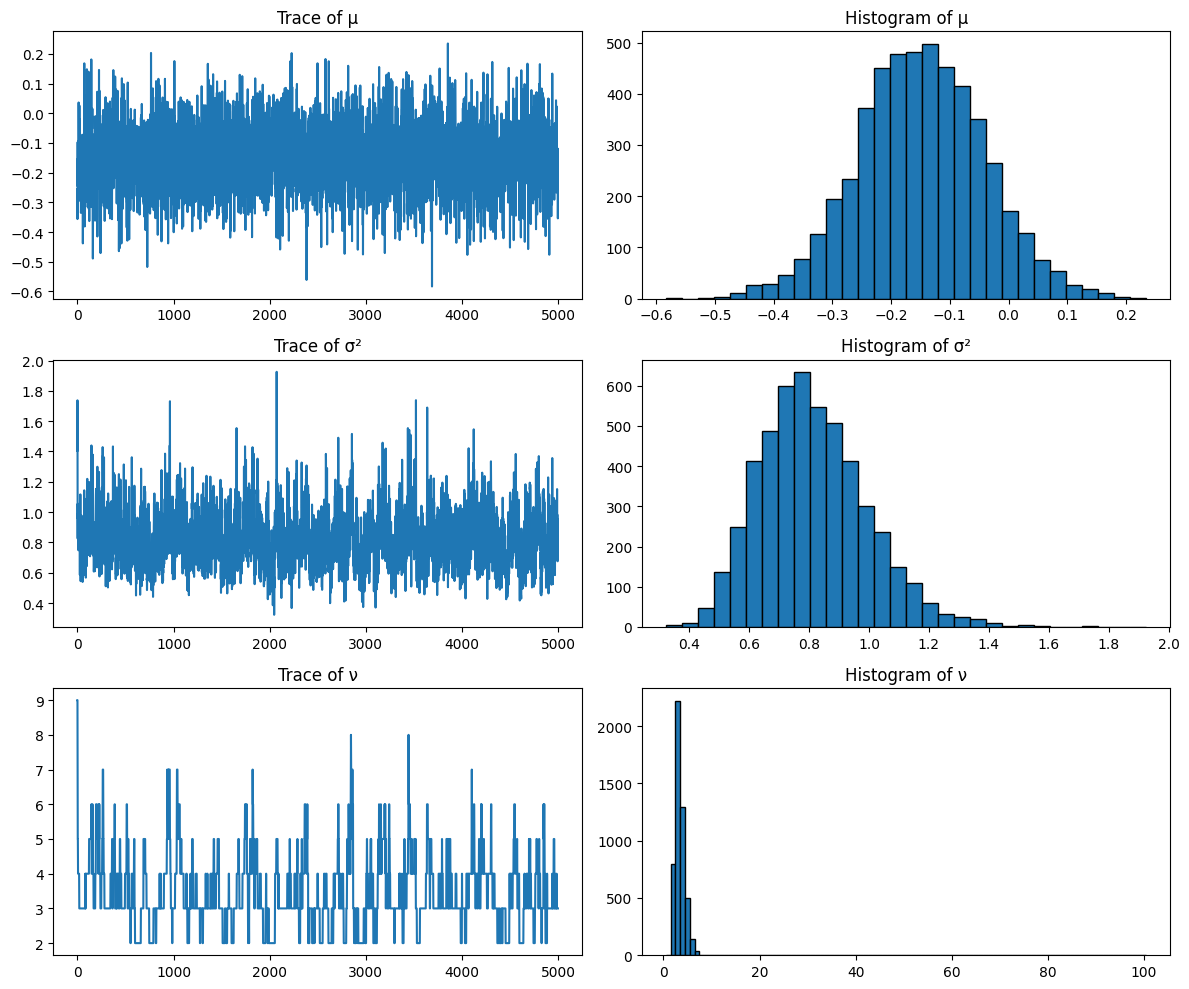

In [6]:
# -------------------------------------------------------------
# Q1: Metropolis-within-Gibbs Sampler Implementation
# -------------------------------------------------------------
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

# Set seed for reproducibility
np.random.seed(42)

# ---- Step 1: Data Simulation and Prior Setup ----
n = 100
true_mu = 0.0
true_sigma = 1.0
true_nu = 5
data = stats.t(df=true_nu, loc=true_mu, scale=true_sigma).rvs(size=n)

# Prior hyperparameters
mu0 = 0.0
tau0 = 1.0    # Precision for the Normal prior on mu
sigma0 = 1.0  # (For a half-normal prior on sigma; not used directly here)
# Prior for nu: Discrete Uniform {1, 2, ..., 100}
nu_candidates = np.arange(1, 101)

# Initial values for parameters and latent variables
mu_current = np.mean(data)
sigma2_current = np.var(data)
nu_current = 10  # Initial guess for nu
lambda_current = np.ones(n)

# MCMC settings
iterations = 5000
mu_samples = np.zeros(iterations)
sigma2_samples = np.zeros(iterations)
nu_samples = np.zeros(iterations)

# Proposal standard deviation for nu (random walk proposal)
proposal_sd_nu = 2

# ---- Step 2: Helper Functions for ν Update ----
def log_prior_nu(nu):
    if nu in nu_candidates:
        return -np.log(len(nu_candidates))
    else:
        return -np.inf

def log_likelihood_nu(nu, lambdas):
    term1 = n * ((nu/2) * np.log(nu/2) - gammaln(nu/2))
    term2 = (nu/2 - 1) * np.sum(np.log(lambdas))
    term3 = -(nu/2) * np.sum(lambdas)
    return term1 + term2 + term3

# ---- Step 3: Metropolis-within-Gibbs Sampling ----
for it in range(iterations):
    # Update each lambda_i
    for i in range(n):
        shape = (nu_current + 1) / 2.0
        rate  = 0.5 * (nu_current + ((data[i] - mu_current)**2 / sigma2_current))
        lambda_current[i] = np.random.gamma(shape, 1.0 / rate)
    
    # Update mu (Normal full conditional)
    prec_data = np.sum(lambda_current) / sigma2_current
    var_mu = 1.0 / (tau0 + prec_data)
    mean_mu = var_mu * (tau0 * mu0 + np.sum(lambda_current * data) / sigma2_current)
    mu_current = np.random.normal(mean_mu, np.sqrt(var_mu))
    
    # Update sigma^2 (Inverse-Gamma update)
    alpha_post = 0.5 * n
    beta_post  = 0.5 * np.sum(lambda_current * (data - mu_current)**2)
    sigma2_current = 1 / np.random.gamma(alpha_post, 1.0 / beta_post)
    
    # Metropolis-Hastings update for nu
    nu_star = int(np.round(nu_current + np.random.normal(0, proposal_sd_nu)))
    nu_star = max(1, min(nu_star, 100))
    log_post_current = log_likelihood_nu(nu_current, lambda_current) + log_prior_nu(nu_current)
    log_post_star    = log_likelihood_nu(nu_star, lambda_current) + log_prior_nu(nu_star)
    if np.log(np.random.rand()) < (log_post_star - log_post_current):
        nu_current = nu_star
    
    # Store samples
    mu_samples[it] = mu_current
    sigma2_samples[it] = sigma2_current
    nu_samples[it] = nu_current

# ---- Step 4: Diagnostics ----
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs[0,0].plot(mu_samples)
axs[0,0].set_title('Trace of μ')
axs[0,1].hist(mu_samples, bins=30, edgecolor='black')
axs[0,1].set_title('Histogram of μ')

axs[1,0].plot(sigma2_samples)
axs[1,0].set_title('Trace of σ²')
axs[1,1].hist(sigma2_samples, bins=30, edgecolor='black')
axs[1,1].set_title('Histogram of σ²')

axs[2,0].plot(nu_samples)
axs[2,0].set_title('Trace of ν')
axs[2,1].hist(nu_samples, bins=np.arange(0.5, 101.5, 1), edgecolor='black')
axs[2,1].set_title('Histogram of ν')

plt.tight_layout()
plt.show()

## Q2: Exploring Sample Size Effects on Inference for \(\nu\) Using PyMC

I divided this problem into two parts:

1. **Model Building and Sampling:**  
   I construct a PyMC model with a Student-\(t\) likelihood and the following priors:
   - \( \mu \sim N(0, 10) \)
   - \( \sigma \sim \text{HalfNormal}(10) \)
   - \( \nu - 2 \sim \text{Exponential}(1.0) \) (ensuring \(\nu > 2\))

2. **Comparative Analysis:**  
   I fit the model using two datasets: one with \(n=100\) (small sample) and another with \(n=1000\) (large sample). I then compare the posterior summaries and visualize the posterior distributions of \(\nu\).

Output()

Output()

Posterior summary for ν (n=100):
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  2.851  0.661     2.0    4.059      0.013    0.009    1830.0    1155.0   

    r_hat  
nu    1.0  

Posterior summary for ν (n=1000):
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  5.592  0.904   4.031     7.28      0.018    0.013    2512.0    2668.0   

    r_hat  
nu    1.0  


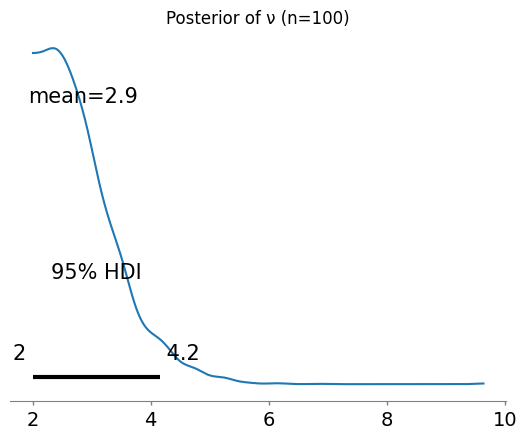

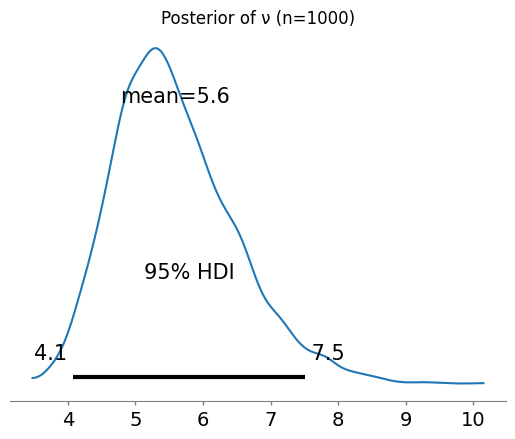

In [11]:
# -------------------------------------------------------------
# Q2: Exploring Sample Size Effects on Inference for ν Using PyMC
# -------------------------------------------------------------
import pymc as pm
import arviz as az

# Set random seed for reproducibility
np.random.seed(42)

# True parameters for simulation
true_mu = 0.0
true_sigma = 1.0
true_nu = 5

# Simulate datasets
data_small = stats.t(df=true_nu, loc=true_mu, scale=true_sigma).rvs(100)
data_large = stats.t(df=true_nu, loc=true_mu, scale=true_sigma).rvs(1000)

def build_model(data):
    with pm.Model() as model:
        # Define nu-2 and then define nu deterministically so that it appears in the trace.
        nu_minus2 = pm.Exponential('nu_minus2', 1.0)
        nu = pm.Deterministic('nu', nu_minus2 + 2)  # ensures nu > 2
        mu = pm.Normal('mu', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=10)
        obs = pm.StudentT('obs', nu=nu, mu=mu, sigma=sigma, observed=data)
    return model

# Build and sample from model with small dataset
model_small = build_model(data_small)
with model_small:
    trace_small = pm.sample(2000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.9)

# Build and sample from model with large dataset
model_large = build_model(data_large)
with model_large:
    trace_large = pm.sample(2000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.9)

# ---- Comparative Analysis ----
print("Posterior summary for ν (n=100):")
print(az.summary(trace_small, var_names=["nu"]))
print("\nPosterior summary for ν (n=1000):")
print(az.summary(trace_large, var_names=["nu"]))

# Plot posterior distributions for ν
az.plot_posterior(trace_small, var_names=["nu"], hdi_prob=0.95)
plt.title('Posterior of ν (n=100)')
plt.show()

az.plot_posterior(trace_large, var_names=["nu"], hdi_prob=0.95)
plt.title('Posterior of ν (n=1000)')
plt.show()

**Observations:**  
- For the small dataset (\(n=100\)), the posterior for \(\nu\) is wide, indicating high uncertainty.  
- For the large dataset (\(n=1000\)), the posterior for \(\nu\) is much more concentrated and centered closer to the true value.  

## Q3: Derivation and Explanation of the Posterior Predictive Distribution

I broke this problem into four concise steps:

1. **Combining Terms:**  
   Write the integral for \(p(y_i \mid \nu)\) by multiplying the likelihood \(p(y_i \mid \tau_i)\) and the prior \(p(\tau_i)\).

2. **Simplifying the Integrand:**  
   Combine the power terms of \(\tau_i\) and the exponential functions to obtain an integrand of the form  
   \(\tau_i^{(\nu-1)/2} \exp\left(-\frac{\tau_i}{2}(y_i^2 + \nu)\right)\).

3. **Evaluating the Integral:**  
   Recognize the resulting integral as a Gamma integral with  
   \(a = \frac{\nu+1}{2}\) and \(b = \frac{y_i^2+\nu}{2}\), so that the integral evaluates to  
   \(\Gamma\left(\frac{\nu+1}{2}\right)/\left(\frac{y_i^2+\nu}{2}\right)^{(\nu+1)/2}\).

4. **Final Expression and Relevance:**  
   Rearrange the expression to obtain the standard Student-\(t\) density:
   \[
   p(y_i \mid \nu) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\pi\nu}\,\Gamma\left(\frac{\nu}{2}\right)} \left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}},
   \]
   and explain that this derivation is analogous to obtaining a posterior predictive distribution by integrating over latent uncertainty.

The detailed derivation is provided in the code below.

In [13]:
# Step 1: Write the integral expression
# p(y_i | nu) = ∫ p(y_i|tau_i) p(tau_i) d(tau_i)
# where:
# p(y_i|tau_i) = sqrt(tau_i/(2*pi)) exp(-0.5*tau_i*y_i^2)
# p(tau_i)    = ((nu/2)^(nu/2) / Gamma(nu/2)) * tau_i^(nu/2-1) exp(-0.5*nu*tau_i)

# Step 2: Combine the tau_i terms:
# tau_i^(1/2) from p(y_i|tau_i) and tau_i^(nu/2-1) from p(tau_i) give:
# tau_i^(1/2 + nu/2 - 1) = tau_i^((nu-1)/2)

# Step 3: Combine exponential terms:
# exp(-0.5*tau_i*y_i^2) * exp(-0.5*nu*tau_i) = exp(-0.5*tau_i*(y_i^2+nu))

# Thus, the integrand becomes:
# Constant C = ((nu/2)^(nu/2))/(Gamma(nu/2)*sqrt(2*pi))
# and the integral:
# ∫_0^∞ tau_i^((nu-1)/2) exp(-0.5*tau_i*(y_i^2+nu)) d(tau_i)

# Recognize this as a Gamma integral:
# ∫_0^∞ tau^(a-1) exp(-b*tau) dtau = Gamma(a)/b^a
# Set a = (nu+1)/2, b = (y_i^2+nu)/2

# Step 4: Final Expression
# p(y_i|nu) = C * [Gamma((nu+1)/2)/((y_i^2+nu)/2)^((nu+1)/2)]
# Rearranging yields the standard Student-t density:
final_expression = (
    "p(y_i | nu) = [Gamma((nu+1)/2)] / [sqrt(pi * nu) * Gamma(nu/2)] * "
    "(1 + y_i^2/nu)^(-((nu+1)/2))"
)
print("Derived marginal density for y_i (Student-t):")
print(final_expression)

Derived marginal density for y_i (Student-t):
p(y_i | nu) = [Gamma((nu+1)/2)] / [sqrt(pi * nu) * Gamma(nu/2)] * (1 + y_i^2/nu)^(-((nu+1)/2))


**Explanation:**  
By integrating out the latent variable \(\tau_i\), we derive the marginal density for \(y_i\) as a Student-\(t\) distribution with \(\nu\) degrees of freedom. This derivation illustrates how averaging (integrating) over latent uncertainty yields a heavy-tailed predictive distribution. Such a process is directly analogous to obtaining a posterior predictive distribution in Bayesian inference, where the uncertainty in parameters is fully accounted for, leading to more robust predictions.

In [14]:
# Print Final Derived Expression
print("\nFinal Derived Expression for p(y_i | nu):")
print(final_expression)


Final Derived Expression for p(y_i | nu):
p(y_i | nu) = [Gamma((nu+1)/2)] / [sqrt(pi * nu) * Gamma(nu/2)] * (1 + y_i^2/nu)^(-((nu+1)/2))
